# Import packages

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from tensorflow import keras
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import metrics
from keras.models import Sequential, load_model
from tensorflow.keras import layers
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Conv1D, Flatten, Dropout, BatchNormalization, Input
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
#from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

In [2]:
# colab 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load Data 

In [ ]:
# jupyter 
df_merge = pd.read_csv("/home/fshokor/Desktop/Uni/coursprog/RAPMC/datas/all_data_clean.txt",sep="\|\|", engine="python")
df_merge.head()

In [3]:
# colab
df_merge = pd.read_csv("/content/gdrive/MyDrive/Kaggle/datas/all_data_clean.txt",sep="\|\|", engine="python")
df_merge.head()

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc...",2
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...,1
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...,1
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c...",1
4,4,CBL,l399v,4,all mutations from the second group were pre...,1


In [4]:
df_merge.shape

(3316, 6)

# Text Preprocessing

In [5]:
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
  # lowercase text
  data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
  # remove numeric values
  data = data.str.replace("\d","")
  # remove punctuations
  data = data.str.replace("[^\w\s]","")
  # remove stopwords: the,a,an etc.
  data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
  return data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
df_merge['Text']= pre_processing(df_merge['Text'])

## Text tokenizer

In [9]:
# Use the Keras tokenizer, vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary)
# the maximum number of words to keep, based on word frequency.
num_words = 700 
seq_len = 700
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_merge['Text'].values) # Updates internal vocabulary based on a list of texts.

In [10]:
# Pad the data 
X = tokenizer.texts_to_sequences(df_merge['Text'].values) # Transforms each text in texts to a sequence of integers, Only top num_words most frequent words will be taken into account.
X = pad_sequences(X, maxlen=seq_len) # transforms a lists of integers into a 2D Numpy array of shape (num_samples, num_timesteps)


In [ ]:
X.shape

(3316, 700)

## Split the data 

In [11]:
Y = pd.get_dummies(df_merge['Class']).values

# split the data into train and test
X_train, text_test, Y_train, y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y)

# split the train data into train and validation
text_train, text_val, y_train, y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.2)
print(text_train.shape, y_train.shape)
print(text_val.shape, y_val.shape)
print(text_test.shape, y_test.shape)

(2121, 700) (2121, 9)
(531, 700) (531, 9)
(664, 700) (664, 9)


## Oversampling 

In [13]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [14]:
# fit and apply the transform
text_train, y_train = oversample.fit_resample(text_train, y_train)
text_train, y_train = oversample.fit_resample(text_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [15]:
print(text_train.shape, y_train.shape)

(3303, 700) (3303, 9)


# Model

## Random model

In [19]:
test_data_len =  text_test.shape[0]
val_data_len = text_val.shape[0]

# create an output array that has exactly same size as the validation data
val_predicted_y = np.zeros((val_data_len,9))
for i in range(val_data_len):
    rand_probs = np.random.rand(1,9)
    val_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])

val_log_loss = round(log_loss(y_val,val_predicted_y, eps=1e-15),2)

print("Log loss on Cross Validation Data using Random Model",val_log_loss)

# Test-Set error.
# create an output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/rand_probs.sum())[0])
test_log_loss = round(log_loss(y_test,test_predicted_y, eps=1e-15),2)

print("Log loss on Test Data using Random Model",test_log_loss)


Log loss on Cross Validation Data using Random Model 2.51
Log loss on Test Data using Random Model 2.45


## Confusion, Recall and Precision Matrix 

In [36]:

def plot_matrices(model, x_test, y_test): 

  probas = model.predict(x_test)
  pred_indices = np.argmax(probas, axis=1)
  classes = np.array(range(1, 10))
  preds = classes[pred_indices]
  print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))
  print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(y_test, axis=1)], preds)))

  confusion  = confusion_matrix(classes[np.argmax(y_test, axis=1)], preds)
  precision =(confusion/confusion.sum(axis=0))
  recall =(((confusion.T)/(confusion.sum(axis=1))).T)
  f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4, gridspec_kw={'width_ratios':[1,1,1,0.08]},figsize=(22,6))
      
  labels = [1,2,3,4,5,6,7,8,9]
  # Confusion matrix 
  g1 = sns.heatmap(confusion,cbar=False,ax=ax1,annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels,)
  g1.set_ylabel('Original Class')
  g1.set_xlabel('Predicted Class')
  g1.set_title('Confusion')

  # Precision matrix 
  g2 = sns.heatmap(precision,cmap="Blues",cbar=False,ax=ax2, annot=True,fmt=".3f", xticklabels=labels, yticklabels=labels)
  g2.set_ylabel('Original Class')
  g2.set_xlabel('Predicted Class')
  g2.set_yticks(labels)
  g2.set_title('Precision')
  
  # Recall matrix 
  g3 = sns.heatmap(recall,cmap="Blues",ax=ax3, cbar_ax=axcb, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
  g3.set_ylabel('Original Class')
  g3.set_xlabel('Predicted Class')
  g3.set_title('Recall')
  g3.set_yticks(labels)
      
  for ax in [g1,g2,g3]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=0)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)
      
  plt.show()


## CNN

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [27]:
num_words = 700
seq_len = 700
embed_dim = 128
lstm_out = 64
batch_size = 32

#### Model building 

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(df_merge['Class']),
                                             df_merge['Class']))


weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

In [23]:
def cnn_model():

  model = Sequential(
    [
     Embedding(num_words, embed_dim, input_length = X.shape[1]),
     Conv1D(64, 5, activation='relu'),
     GlobalMaxPooling1D(),
     Dropout(0.2),
     Flatten(),
     Dense(16, activation='relu'),
     Dense(9, activation='softmax')
    ]
  )
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  
  return model






In [25]:
model = cnn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 700, 128)          89600     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 696, 64)           41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                

#### Plot the model 

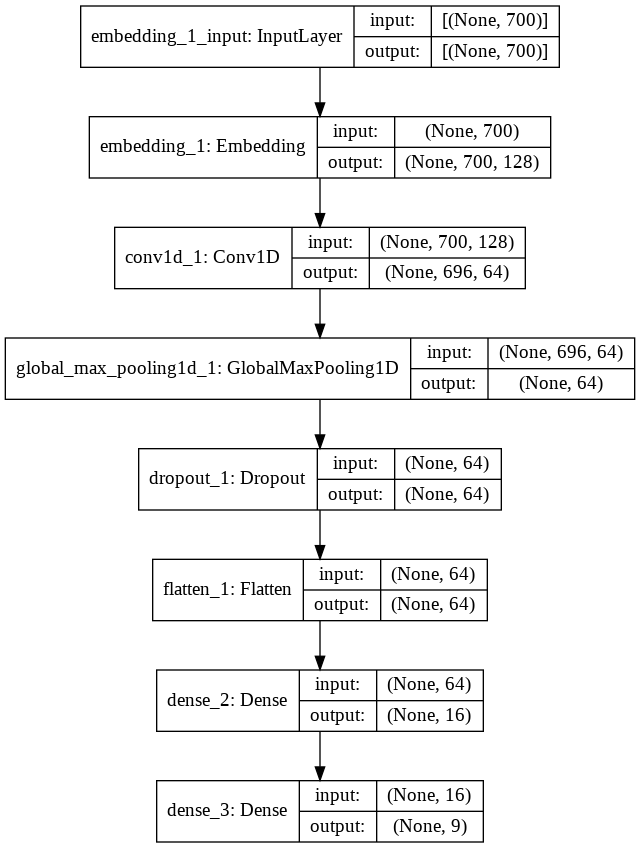

In [26]:
keras.utils.plot_model(model, "my_first_model_shapes.png", show_shapes= True)

#### Model Training 

In [30]:
history = model.fit(text_train, y_train,
                      #class_weight=weights,
                      epochs=50,
                      verbose=False,
                      validation_data =(text_val, y_val),
                      batch_size= batch_size , 
                      callbacks= callback)

In [31]:
loss, accuracy = model.evaluate(text_train, y_train, verbose=False)
print("Training Accuracy: >%.3f"  % (accuracy * 100.0))

Training Accuracy: >97.972


#### Model Testing 

In [32]:
loss, accuracy = model.evaluate(text_test, y_test, verbose=False)
print("Testing Accuracy:  >%.3f"  % (accuracy * 100.0))

Testing Accuracy:  >64.157


#### confusion matrix

Log loss: 1.1992573551199612
Accuracy: 0.641566265060241


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


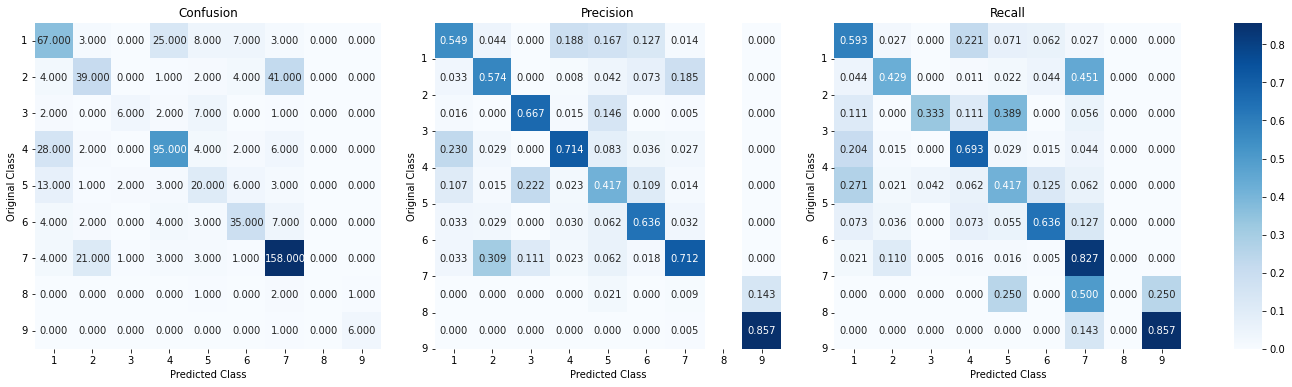

In [37]:
plot_matrices(model,text_test, y_test )

#### Plot Model loss and accuracy

In [38]:
# list all data history 
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<function matplotlib.pyplot.show>

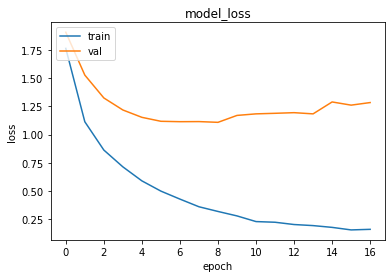

In [39]:
# visualize training and validation losses  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show 

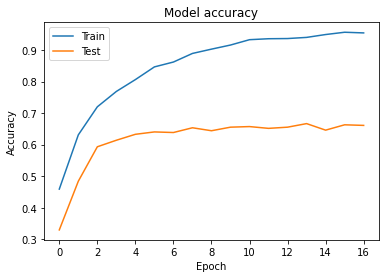

In [40]:
# visualize training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()